# Attribution and Motifs Detection with Decima

This documentation demonstrates how to use Decima's attribution analysis capabilities to identify important regulatory regions in genomic sequences and discover transcription factor binding motifs within those regions. Attribution analysis helps reveal which parts of the DNA sequence most strongly influence gene expression predictions, while **motif scanning** can identify specific transcription factor binding sites in these regions of interest.

In [1]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

%matplotlib inline

### Python User API


Let's look at a simple example using Decima's Python API to analyze the SPI1 gene, which is a key transcription factor in myeloid cell development. We'll examine its regulation across different monocyte and macrophage cell types where it is known to be important.

First we choice the cells, we are interested in:


In [2]:
spi1_cell_types = [
    "classical monocyte",
    "intermediate monocyte",
    "non-classical monocyte",
    "alveolar macrophage",
    "macrophage",
]

In [3]:
from decima import predict_save_attributions

predict_save_attributions(
    output_dir="attrs_SP1I_monoctypes",
    gene="SPI1",
    tasks=f"cell_type in {spi1_cell_types}",
    device=device,
)

wandb: Currently logged in as: celikm5 (celikm5-genentech) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Downloading large artifact decima_metadata:latest, 628.05MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.5 (1295.5MB/s)
wandb: Downloading large artifact decima_rep0:latest, 2155.88MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.1 (1957.8MB/s)
wandb: Downloading large artifact human_state_dict_fold0:latest, 709.30MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.4 (1589.8MB/s)
/home/celikm5/miniforge3/envs/decima/lib/python3.11/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
/home/celikm5/miniforge3/envs/decima/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6 x 2 in image.
/home/celikm5/miniforge3/envs/decima/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning:

This comments creates following files in the directory:

        |- qc.log : QC warnings check if the predictions are relable for the peak
        |- peaks.bed : list of attribution peaks 
        |- peaks.png : plot of peak locations
        |- motifs.tsv : motifs detected in the peaks
        |- attributions_scores.tsv : attiribution score matrix for the seq
        |- attributions.bigwig : bigwig file for attributinos scores
        |- attributions : plots for attribution scores
                |- {attribution}.png

You can simply load `peaks.bed` and  `attributions.bigwig` to IGV and investigate important elements.


### Simple CLI API

Same operations can be also performed with the CLI. 

In [4]:
! decima attributions --gene "SPI1" --tasks "cell_type == 'classical monocyte'" --device {device} --output_dir cli_attrs_SP1I_classical_monoctypes/

decima.interpret.save_attributions - INFO - Loading model and metadata to compute attributions...
wandb: Currently logged in as: celikm5 (celikm5-genentech) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Downloading large artifact decima_metadata:latest, 628.05MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.5 (1315.1MB/s)
wandb: Downloading large artifact decima_rep0:latest, 2155.88MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.1 (2029.0MB/s)
wandb: Downloading large artifact human_state_dict_fold0:latest, 709.30MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.5 (1463.2MB/s)
/home/celikm5/miniforge3/envs/decima/lib/python3.11/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
decima.interpret.save_attributions - INFO - Writing QC log...
decima.interpret.save_attributions - INFO - Saving peaks...
/home/celikm5/mi

See further details of attributions with:

In [5]:
! decima attributions --help

Usage: decima attributions [OPTIONS]

  Generate and save attribution analysis results for a gene.

  Examples:

      >>> decima attributions -o output_dir -g SPI1 --tasks "cell_type ==
      'classical monocyte'" --device 0

  Output files:

      output_dir/

      ├── peaks.bed                # List of attribution peaks in BED format

      ├── peaks.png                # Plot showing peak locations

      ├── qc.log                   # QC warnings about prediction reliability

      ├── motifs.tsv               # Detected motifs in peak regions

      ├── attributions.npz         # Raw attribution score matrix

      ├── attributions.bigwig      # Genome browser track of attribution
      scores

      └── attributions_seq_logos/  # Directory containing attribution plots

          └── {peak}.png           # Attribution plot for each peak region

Options:
  -o, --output_dir TEXT  Directory to save output files  [required]
  -g, --gene TEXT        Gene symbol or ID to analyze  [requ

### Advance Developer API

`DecimaResult` provides a unified interface for working with Decima results in anndata format. It contains an AnnData structure storing cell x gene expression data and metadata. Through DecimaResult, users can load pre-trained models, compute attributions to  understand genomic regulation, and analyze results through visualizations or export to genomic file formats. The object provides convenient access to cell and gene annotations through its metadata properties.

In [6]:
from decima.core import DecimaResult

result = DecimaResult.load()
result.load_model(device=device)

wandb: Downloading large artifact decima_metadata:latest, 628.05MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.5 (1186.3MB/s)
wandb: Downloading large artifact decima_rep0:latest, 2155.88MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.1 (2003.8MB/s)
wandb: Downloading large artifact human_state_dict_fold0:latest, 709.30MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.5 (1513.1MB/s)


DecimaResult(anndata=AnnData object with n_obs × n_vars = 8856 × 18457
    obs: 'cell_type', 'tissue', 'organ', 'disease', 'study', 'dataset', 'region', 'subregion', 'celltype_coarse', 'n_cells', 'total_counts', 'n_genes', 'size_factor', 'train_pearson', 'val_pearson', 'test_pearson'
    var: 'chrom', 'start', 'end', 'strand', 'gene_type', 'frac_nan', 'mean_counts', 'n_tracks', 'gene_start', 'gene_end', 'gene_length', 'gene_mask_start', 'gene_mask_end', 'frac_N', 'fold', 'dataset', 'gene_id', 'pearson', 'size_factor_pearson'
    uns: 'log1p'
    layers: 'preds')

The results and metadata stored in anndata format which you can access directly if needed but most operation are supported by DecimaResult object.

In [7]:
result.anndata

AnnData object with n_obs × n_vars = 8856 × 18457
    obs: 'cell_type', 'tissue', 'organ', 'disease', 'study', 'dataset', 'region', 'subregion', 'celltype_coarse', 'n_cells', 'total_counts', 'n_genes', 'size_factor', 'train_pearson', 'val_pearson', 'test_pearson'
    var: 'chrom', 'start', 'end', 'strand', 'gene_type', 'frac_nan', 'mean_counts', 'n_tracks', 'gene_start', 'gene_end', 'gene_length', 'gene_mask_start', 'gene_mask_end', 'frac_N', 'fold', 'dataset', 'gene_id', 'pearson', 'size_factor_pearson'
    uns: 'log1p'
    layers: 'preds'

These are the cell metadata contained in the Decima object.

In [8]:
result.cell_metadata

,cell_type,tissue,organ,disease,study,dataset,region,subregion,celltype_coarse,n_cells,total_counts,n_genes,size_factor,train_pearson,val_pearson,test_pearson
agg_0,Amygdala excitatory,Amygdala_Amygdala,CNS,healthy,jhpce#tran2021,brain_atlas,Amygdala,Amygdala,NaN,331,1.592883e+07,17000,41431.465186,0.942474,0.841879,0.865579
agg_1,Amygdala excitatory,Amygdala_Basolateral nuclear group (BLN) - lat...,CNS,healthy,SCR_016152,brain_atlas,Amygdala,Basolateral nuclear group (BLN) - lateral nucl...,NaN,11369,2.952133e+08,18080,40765.341481,0.943247,0.839565,0.860787
agg_2,Amygdala excitatory,Amygdala_Bed nucleus of stria terminalis and n...,CNS,healthy,SCR_016152,brain_atlas,Amygdala,Bed nucleus of stria terminalis and nearby - BNST,NaN,139,2.593231e+06,15418,42556.387020,0.952271,0.855175,0.866643
agg_3,Amygdala excitatory,Amygdala_Central nuclear group - CEN,CNS,healthy,SCR_016152,brain_atlas,Amygdala,Central nuclear group - CEN,NaN,3892,9.946371e+07,17959,42884.641430,0.959857,0.863817,0.881534
agg_4,Amygdala excitatory,Amygdala_Corticomedial nuclear group (CMN) - a...,CNS,healthy,SCR_016152,brain_atlas,Amygdala,Corticomedial nuclear group (CMN) - anterior c...,NaN,2945,1.281619e+08,17885,41816.741933,0.951541,0.855172,0.868277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
agg_9533,vascular associated smooth muscle cell,upper lobe of right lung,lung,NA,ENCODE,scimilarity,nan,nan,NaN,21,3.483375e+04,8515,35404.911768,0.736001,0.664692,0.655120
agg_9535,vascular associated smooth muscle cell,urinary bladder,urinary,healthy,GSE129845,scimilarity,nan,nan,NaN,24,8.498500e+04,7337,26189.415789,0.810245,0.690370,0.656580
agg_9536,vascular associated smooth muscle cell,uterus,uterus,NA,ENCODE,scimilarity,nan,nan,NaN,272,5.700762e+05,14769,44938.403867,0.915162,0.807299,0.841429
agg_9537,vascular associated smooth muscle cell,uterus,uterus,healthy,e5f58829-1a66-40b5-a624-9046778e74f5,scimilarity,nan,nan,NaN,472,1.089170e+07,14514,30145.422152,0.852446,0.717448,0.729172


Similarly, these are the gene metadata contained in the Decima object.

In [9]:
result.gene_metadata

,chrom,start,end,strand,gene_type,frac_nan,mean_counts,n_tracks,gene_start,gene_end,gene_length,gene_mask_start,gene_mask_end,frac_N,fold,dataset,gene_id,pearson,size_factor_pearson
STRADA,chr17,63381538,63905826,-,protein_coding,0.000000,2.208074,7616,63682336,63741986,59650,163840,223490,0.000000,['fold1'],train,ENSG00000266173,0.492455,0.476627
ETV4,chr17,43219172,43743460,-,protein_coding,0.030873,0.925863,5004,43527844,43579620,51776,163840,215616,0.000000,['fold1'],train,ENSG00000175832,0.737548,0.613281
USP25,chr21,15566185,16090473,+,protein_coding,0.000000,3.650355,8604,15730025,15880069,150044,163840,313884,0.000000,['fold6'],train,ENSG00000155313,0.905298,0.784446
ZSWIM5,chr1,44945761,45470049,-,protein_coding,0.000620,2.190115,6123,45016399,45306209,289810,163840,453650,0.000000,['fold5'],train,ENSG00000162415,0.961775,0.795131
C21orf58,chr21,45963427,46487715,-,protein_coding,0.000791,1.650467,7354,46300181,46323875,23694,163840,187534,0.000000,['fold6'],train,ENSG00000160298,0.645260,0.412368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NPDC1,chr9,136685731,137210019,-,protein_coding,0.000000,2.625285,7852,137039463,137046179,6716,163840,170556,0.000000,['fold3'],test,ENSG00000107281,0.328081,0.178204
ZNF425,chr7,148765876,149290164,-,protein_coding,0.001048,1.292957,6511,149102784,149126324,23540,163840,187380,0.000000,['fold7'],train,ENSG00000204947,0.818260,0.737081
COL5A1,chr9,134477934,135002222,+,protein_coding,0.002159,1.492664,6209,134641774,134844843,203069,163840,366909,0.000000,['fold3'],test,ENSG00000130635,0.766627,0.456999
BRD3,chr9,133708087,134232375,-,protein_coding,0.000000,3.190450,8675,134030305,134068535,38230,163840,202070,0.004662,['fold3'],test,ENSG00000169925,0.345257,0.280283


You can also access the genes and cells:

In [10]:
result.genes

Index(['STRADA', 'ETV4', 'USP25', 'ZSWIM5', 'C21orf58', 'MIR497HG', 'CFAP74',
       'GSE1', 'LPP', 'CLK1',
       ...
       'STRIP2', 'TNFRSF1A', 'RBM14-RBM4', 'C1orf21', 'LINC00639', 'NPDC1',
       'ZNF425', 'COL5A1', 'BRD3', 'EVI5L'],
      dtype='object', length=18457)

Cell indexes can be also accessed:

In [11]:
result.cells

Index(['agg_0', 'agg_1', 'agg_2', 'agg_3', 'agg_4', 'agg_5', 'agg_6', 'agg_7',
       'agg_8', 'agg_9',
       ...
       'agg_9528', 'agg_9529', 'agg_9530', 'agg_9531', 'agg_9532', 'agg_9533',
       'agg_9535', 'agg_9536', 'agg_9537', 'agg_9538'],
      dtype='object', length=8856)

Predicted gene expression for specific gene can be accessed:

In [12]:
result.predicted_expression_matrix(genes=["SPI1"])

,SPI1
agg_0,0.235185
agg_1,0.206469
agg_2,0.152874
agg_3,0.206552
agg_4,0.208177
...,...
agg_9533,0.473107
agg_9535,0.268442
agg_9536,0.336398
agg_9537,0.137872


Or for all the genes:

In [13]:
result.predicted_expression_matrix()

,STRADA,ETV4,USP25,ZSWIM5,C21orf58,MIR497HG,CFAP74,GSE1,LPP,CLK1,...,STRIP2,TNFRSF1A,RBM14-RBM4,C1orf21,LINC00639,NPDC1,ZNF425,COL5A1,BRD3,EVI5L
agg_0,3.001925,1.762730,4.592772,5.099946,1.774805,0.356839,2.723968,4.739502,4.878714,3.327033,...,2.920594,0.297011,1.813074,4.493094,1.586075,3.319982,2.364579,2.374891,2.890716,3.253235
agg_1,3.003353,1.782654,4.723227,5.510479,1.666820,0.352753,2.425501,4.544352,4.855130,3.192972,...,3.227516,0.242533,1.818673,4.679863,1.348369,3.632192,2.463864,2.054537,2.700207,3.452777
agg_2,2.978871,2.089668,4.865537,5.617505,1.773259,0.380907,2.543027,4.512998,4.782970,3.390886,...,3.180318,0.263283,1.930930,4.540818,1.299774,4.154801,2.433835,2.297276,2.890761,3.629054
agg_3,3.074754,2.038535,4.884157,5.273578,1.760010,0.463595,2.543533,4.039080,4.854626,3.411034,...,2.939788,0.290311,1.847241,4.780760,1.529227,3.828480,2.331008,2.121762,2.608462,3.186322
agg_4,3.103840,1.959215,4.590865,5.256962,1.755244,0.382228,2.587021,4.453868,4.932796,3.250587,...,3.205086,0.258538,1.966316,4.641990,1.326930,3.780137,2.444831,2.255797,2.889546,3.451440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
agg_9533,2.289689,0.581705,4.639077,2.793091,0.751956,0.692147,0.568351,4.420611,6.842777,3.695646,...,0.549443,2.270267,1.523273,4.432419,0.614325,1.389469,1.054450,3.759573,2.514814,1.981362
agg_9535,0.833283,0.326443,1.960863,0.307475,0.337182,0.834267,0.110843,1.929069,3.701684,4.467318,...,0.178374,1.370960,1.084590,3.587358,0.068649,1.980652,0.240619,1.448074,1.673506,1.171897
agg_9536,3.036649,1.131592,4.749751,3.931905,1.401179,1.638554,1.078200,4.855861,6.520594,4.127848,...,1.195112,1.870594,2.443540,5.207511,1.023207,1.918750,2.230703,4.244238,2.968915,2.759851
agg_9537,1.264902,0.410833,2.903708,0.571702,0.486362,1.175724,0.165795,2.461262,4.814781,4.913913,...,0.373774,1.361205,1.722287,4.142306,0.095901,1.665432,0.493823,2.066999,2.361383,1.569963


Takes around ~10 seconds on GPU and ~5 minutes to call attributions on CPU. 

In [14]:
attributions = result.attributions(
    gene="SPI1",
    tasks=f"cell_type in {spi1_cell_types}",
    off_tasks=f'organ == "blood" and cell_type not in {spi1_cell_types}',
)

/home/celikm5/miniforge3/envs/decima/lib/python3.11/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.


Attributions can be visualized and processed with attributions object:

In [15]:
attributions

Attribution(gene=SPI1)

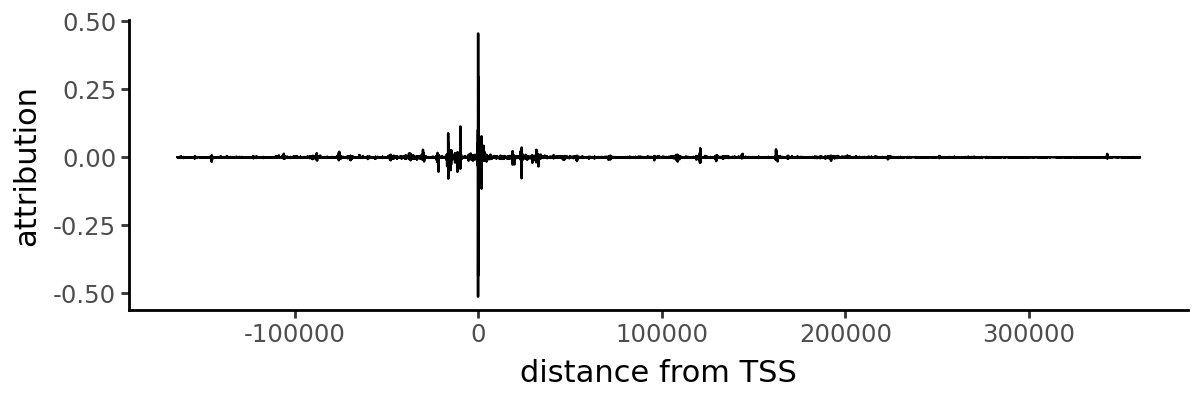

In [16]:
attributions.plot_peaks()

Attributions has same size as input size of the model:

In [17]:
attributions.attrs

array([[-0.0000000e+00,  0.0000000e+00, -0.0000000e+00, ...,
        -0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [-0.0000000e+00, -0.0000000e+00, -2.7136472e-05, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [-0.0000000e+00,  1.2634220e-04,  0.0000000e+00, ...,
         3.7220303e-05, -0.0000000e+00,  1.5047322e-05],
       [ 1.7313290e-04, -0.0000000e+00,  0.0000000e+00, ...,
        -0.0000000e+00,  1.2202940e-05, -0.0000000e+00]], dtype=float32)

In [18]:
attributions.tss_pos

47378576

In [19]:
attributions.plot_attributions(relative_loc=0, window=50)

In [20]:
attributions.plot_attributions(relative_loc=-45)

This comment takes around ~1 minutes and detects motifs in the attributions using FIMO. The motifs are ranked by their attribution scores:

In [21]:
df_motifs = attributions.scan_motifs()
df_motifs

/home/celikm5/miniforge3/envs/decima/lib/python3.11/site-packages/tangermeme/tools/fimo.py:406: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
/home/celikm5/miniforge3/envs/decima/lib/python3.11/site-packages/tangermeme/tools/fimo.py:406: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
/home/celikm5/miniforge3/envs/decima/lib/python3.11/site-packages/tangermeme/tools/fimo.py:406: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this

,motif,sequence,peak,start,end,strand,score,p-value,matched_seq,site_attr_score,motif_attr_score,peak,height,from_tss
0,CEBPA.H12CORE.0.P.B,0,SPI1@-45,0,12,+,7.964049,0.000345,TGTAGCGCAAGA,0.165488,0.576723,163795,1.822603,-45
1,CEBPB.H12CORE.1.SM.B,0,SPI1@-45,0,13,+,4.519608,0.000355,TGTAGCGCAAGAG,0.157533,0.547989,163795,1.822603,-45
2,CEBPD.H12CORE.1.SM.B,0,SPI1@-45,0,13,-,6.831978,0.000445,TGTAGCGCAAGAG,0.157533,0.530259,163795,1.822603,-45
3,CEBPG.H12CORE.1.SM.B,0,SPI1@-45,0,12,-,7.931759,0.000198,TGTAGCGCAAGA,0.165488,0.588917,163795,1.822603,-45
4,KAISO.H12CORE.0.P.B,0,SPI1@-45,2,13,+,8.282666,0.000324,TAGCGCAAGAG,0.161963,0.443649,163795,1.822603,-45
5,EHF.H12CORE.0.P.B,1,SPI1@38,1,16,+,9.409240,0.000136,AAATCAGGAACTTGT,0.114111,0.299546,163878,1.187623,38
6,ELF1.H12CORE.0.PSM.A,1,SPI1@38,2,15,+,8.124340,0.000287,AATCAGGAACTTG,0.111785,0.298921,163878,1.187623,38
7,ELF3.H12CORE.0.S.B,1,SPI1@38,2,15,+,6.618979,0.000462,AATCAGGAACTTG,0.111785,0.310930,163878,1.187623,38
8,ELF3.H12CORE.1.PM.A,1,SPI1@38,2,15,+,5.230852,0.000330,AATCAGGAACTTG,0.111785,0.318128,163878,1.187623,38
9,ELF4.H12CORE.1.M.B,1,SPI1@38,0,15,+,6.834103,0.000242,AAAATCAGGAACTTG,0.114821,0.286368,163878,1.187623,38


### Writing Advance queries

To obtain attributions, cells of interest must be selected using the query API. We support Pandas' query API functionality on the cell metadata DataFrame. Here are examples of how to write queries

In [22]:
# Query cells of type "classical monocyte" using Pandas query syntax
cells = result.query_cells(query='cell_type == "classical monocyte"')

In [23]:
# This query selects cells that are:
# - classical monocytes (cell_type == "classical monocyte")
# - from healthy donors (disease == "healthy")
# - from blood tissue (tissue == "blood")
cells = result.query_cells('cell_type == "classical monocyte" and disease == "healthy" and tissue == "blood"')

In [24]:
# Query cells that:
# - have "monocyte" in their cell type name (cell_type.str.contains("monocyte"))
# - are from healthy donors (disease == "healthy")
cells = result.query_cells('cell_type.str.contains("monocyte") and disease == "healthy"')

In [25]:
# Previous query is equivalent to using pandas boolean indexing directly:
df_cell_metadata = result.cell_metadata

cells = df_cell_metadata[
    df_cell_metadata["cell_type"].str.contains("monocyte") & (df_cell_metadata["disease"] == "healthy")
].index